# Data analysis

## 0. Setup

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path
import sys

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. Descriptive statistics

### 1.1. Referrals

### 1.2. HIU

### 1.3. SNAP EDA

## 2. Exhaustiveness analysis of referrals

I have ran the following scripts to infer adverse SDoH from referrals of the SNAP and HIU datasets using the direct pipeline. 

```console
python scripts/inference_adverse/infer_adverse_sdoh_direct.py \
    --model_dir results/model_training/llama_multilabel_direct_adverse/best_model/Llama-3.1-8B-Instruct_bs8_lr3e-05_epochs6_20250726_031804 \
    --dataset_path data/processed/brc-cleaned/hiu_final.csv
```

```console
python scripts/inference_adverse/infer_adverse_sdoh_direct.py \
    --model_dir results/model_training/llama_multilabel_direct_adverse/best_model/Llama-3.1-8B-Instruct_bs8_lr3e-05_epochs6_20250726_031804 \
    --dataset_path data/processed/brc-cleaned/snap_final.csv`
```

### 2.1. Data prep

In [8]:
from src.analysis_helpers import (
    load_and_merge_structured_and_predictions,
    create_exhaustiveness_long_format,
    summarize_exhaustiveness
)

**HIU**

In [9]:
hiu_structured_path =  "../data/processed/brc-cleaned/hiu_final.csv"
hiu_predictions_path = "../results/inference/hiu_final_Llama-3.1-8B-Instruct_bs8_lr3e-05_epochs6_20250726_031804_predictions/predictions.csv"

# Define the mapping for structured data to labels
hiu_mapping = {
    "housing_need": "housing",
    "finances_need": "finances",
    "loneliness_need": "loneliness"
}

# Load and merge the structured data with predictions for the HIU dataset
df_hiu = load_and_merge_structured_and_predictions(
    structured_path=hiu_structured_path,
    predictions_path=hiu_predictions_path
)

# Create the long format DataFrame
df_hiu_long = create_exhaustiveness_long_format(
    df_merged=df_hiu,
    structured_to_label=hiu_mapping
)

df_hiu_summary = summarize_exhaustiveness(df_hiu_long)

print("=== HIU Dataset: SDoH Exhaustiveness Summary ===")
display(df_hiu_summary)

# Pivot the long-format DataFrame back to wide format
df_hiu_wide_augmented = df_hiu_long.pivot(
    index="case_ref",
    columns="sdoh_category",
    values="documentation_status"
).reset_index()

# Rename columns to make the names clearer
df_hiu_wide_augmented = df_hiu_wide_augmented.rename(columns={
    "housing": "documentation_status_housing",
    "finances": "documentation_status_finances",
    "loneliness": "documentation_status_loneliness"
})

# Merge back with original df_hiu for additional columns
df_hiu_augmented = df_hiu.merge(df_hiu_wide_augmented, on="case_ref", how="left")

# Save the augmented DataFrame to a CSV file
output_path = "../data/processed/post-inference/hiu_with_labels.csv"
df_hiu_augmented.to_csv(output_path, index=False)

=== HIU Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Experienced and documented in referral,Experienced but not documented in referral,Neither experienced nor documented in referral,Not experienced but documented in referral
sdoh_category,,,,
finances,49,256,718,65
housing,118,251,648,71
loneliness,134,690,237,27


**SNAP**

In [19]:
snap_structured_path = "../data/processed/brc-cleaned/snap_final.csv"
snap_predictions_path = "../results/inference/snap_final_Llama-3.1-8B-Instruct_bs8_lr3e-05_epochs6_20250726_031804_predictions/predictions.csv"

snap_mapping = {
    "housing_need": "housing",
    "loneliness_need": "loneliness",
    "finances_need": "finances",
    "food_insecurity_need": "foodaccess"
}

df_snap = load_and_merge_structured_and_predictions(
    structured_path=snap_structured_path,
    predictions_path=snap_predictions_path
)

df_snap_long = create_exhaustiveness_long_format(
    df_merged=df_snap,
    structured_to_label=snap_mapping
)

df_snap_summary = summarize_exhaustiveness(df_snap_long)

print("=== SNAP Dataset: SDoH Exhaustiveness Summary ===")
display(df_snap_summary)

# Pivot the long-format DataFrame back to wide format
df_snap_wide_augmented = df_snap_long.pivot_table(
    index="case_ref",
    columns="sdoh_category",
    values="documentation_status",
    aggfunc="first" 
).reset_index()

# Rename columns to make the names clearer
df_snap_wide_augmented = df_snap_wide_augmented.rename(columns={
    "housing": "documentation_status_housing",
    "finances": "documentation_status_finances",
    "loneliness": "documentation_status_loneliness",
    "foodaccess": "documentation_status_foodaccess"
})

# Merge back with original df_hiu for additional columns
df_snap_augmented = df_snap.merge(df_snap_wide_augmented, on="case_ref", how="left")

# Save the augmented DataFrame to a CSV file
output_path = "../data/processed/post-inference/snap_with_labels.csv"
df_snap_augmented.to_csv(output_path, index=False)

=== SNAP Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Experienced and documented in referral,Experienced but not documented in referral,Neither experienced nor documented in referral,Not experienced but documented in referral
sdoh_category,,,,
finances,38,153,492,26
foodaccess,91,73,416,129
housing,44,134,480,51
loneliness,88,236,350,35


In [20]:
df_hiu_long["dataset"] = "HIU"
df_snap_long["dataset"] = "SNAP"
df_combined_long = pd.concat([df_hiu_long, df_snap_long])

In [21]:
df_combined_long.columns

Index(['case_ref', 'sdoh_category', 'structured_experienced',
       'free_text_documented', 'documentation_status', 'dataset'],
      dtype='object')

### 2.2. Initial visualisations

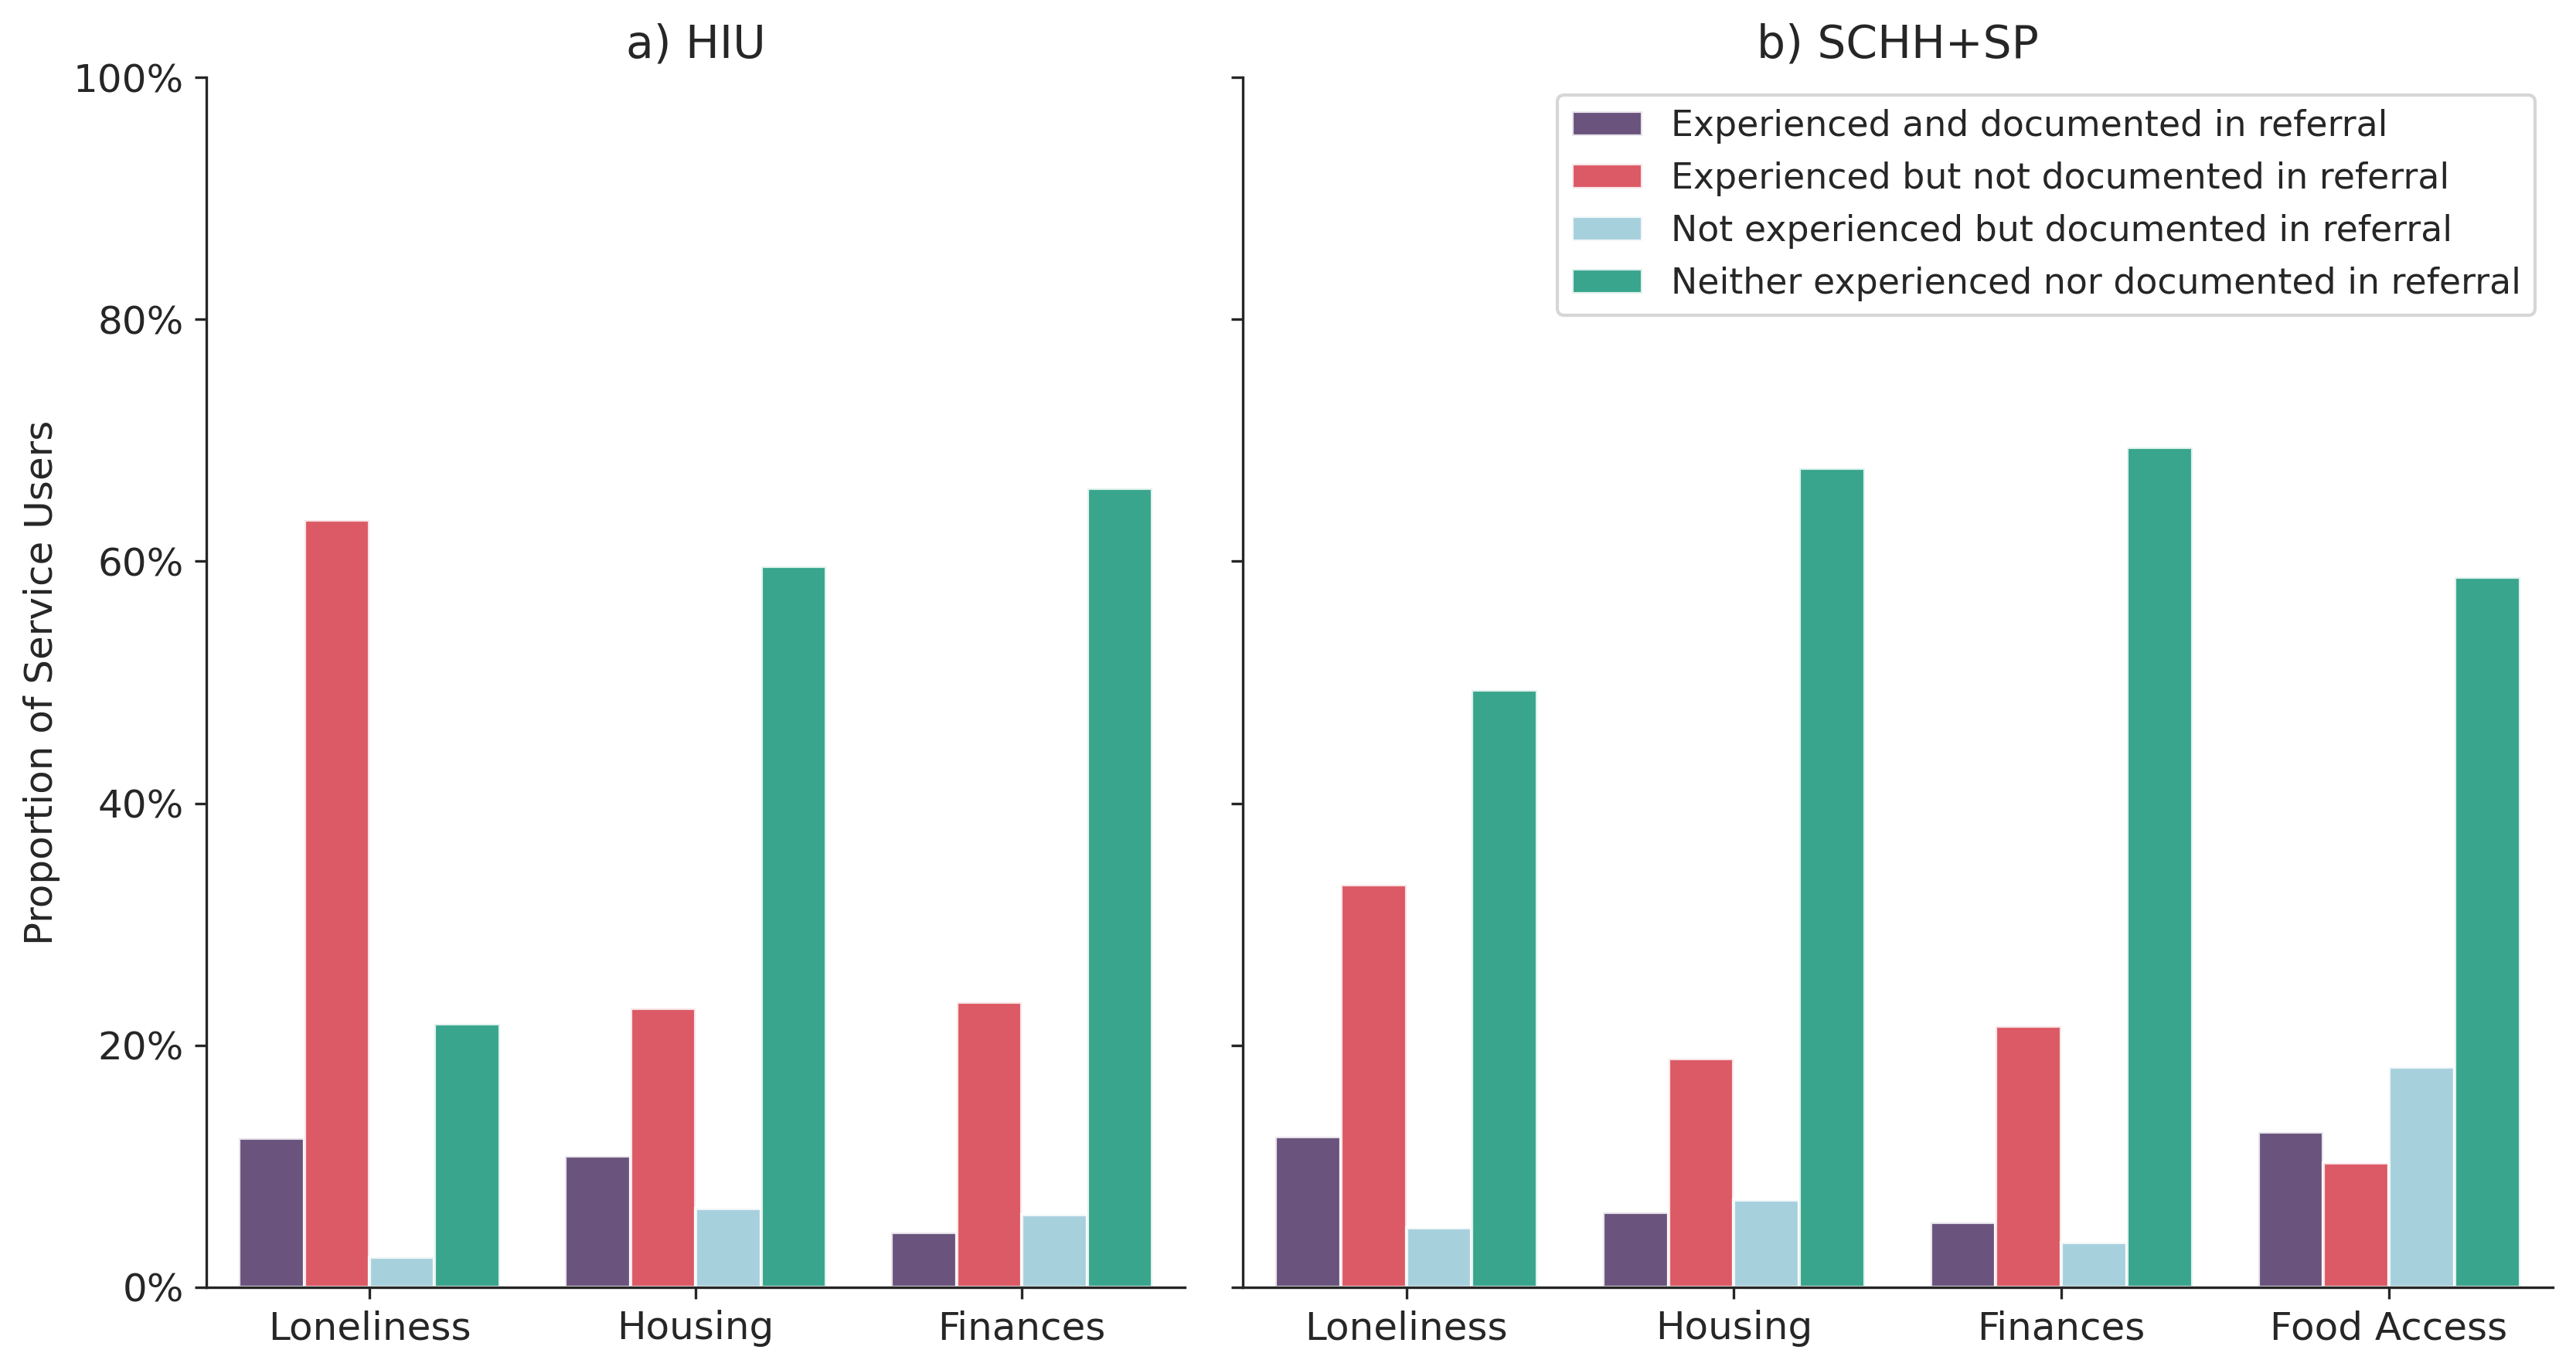

In [119]:
from src.visualisations_helpers import compute_proportions, plot_single_dataset_proportion

df_prop = compute_proportions(df_combined_long)

plot_single_dataset_proportion(df_prop, "HIU", "../results/figures/hiu_prop_plot.png", figsize=(5.3, 6))
plot_single_dataset_proportion(df_prop, "SNAP", "../results/figures/snap_prop_plot.png", figsize=(6, 6))

# Combine horizontally (same as before)
from PIL import Image

img1 = Image.open("../results/figures/hiu_prop_plot.png")
img2 = Image.open("../results/figures/snap_prop_plot.png")

img1 = img1.resize((img1.width, img2.height))  # ensure same height

combined = Image.new('RGB', (img1.width + img2.width, img2.height), (255, 255, 255))
combined.paste(img1, (0, 0))
combined.paste(img2, (img1.width, 0))
combined.save("../results/figures/notes_exhaustiveness_combined_prop.png")
combined.show()


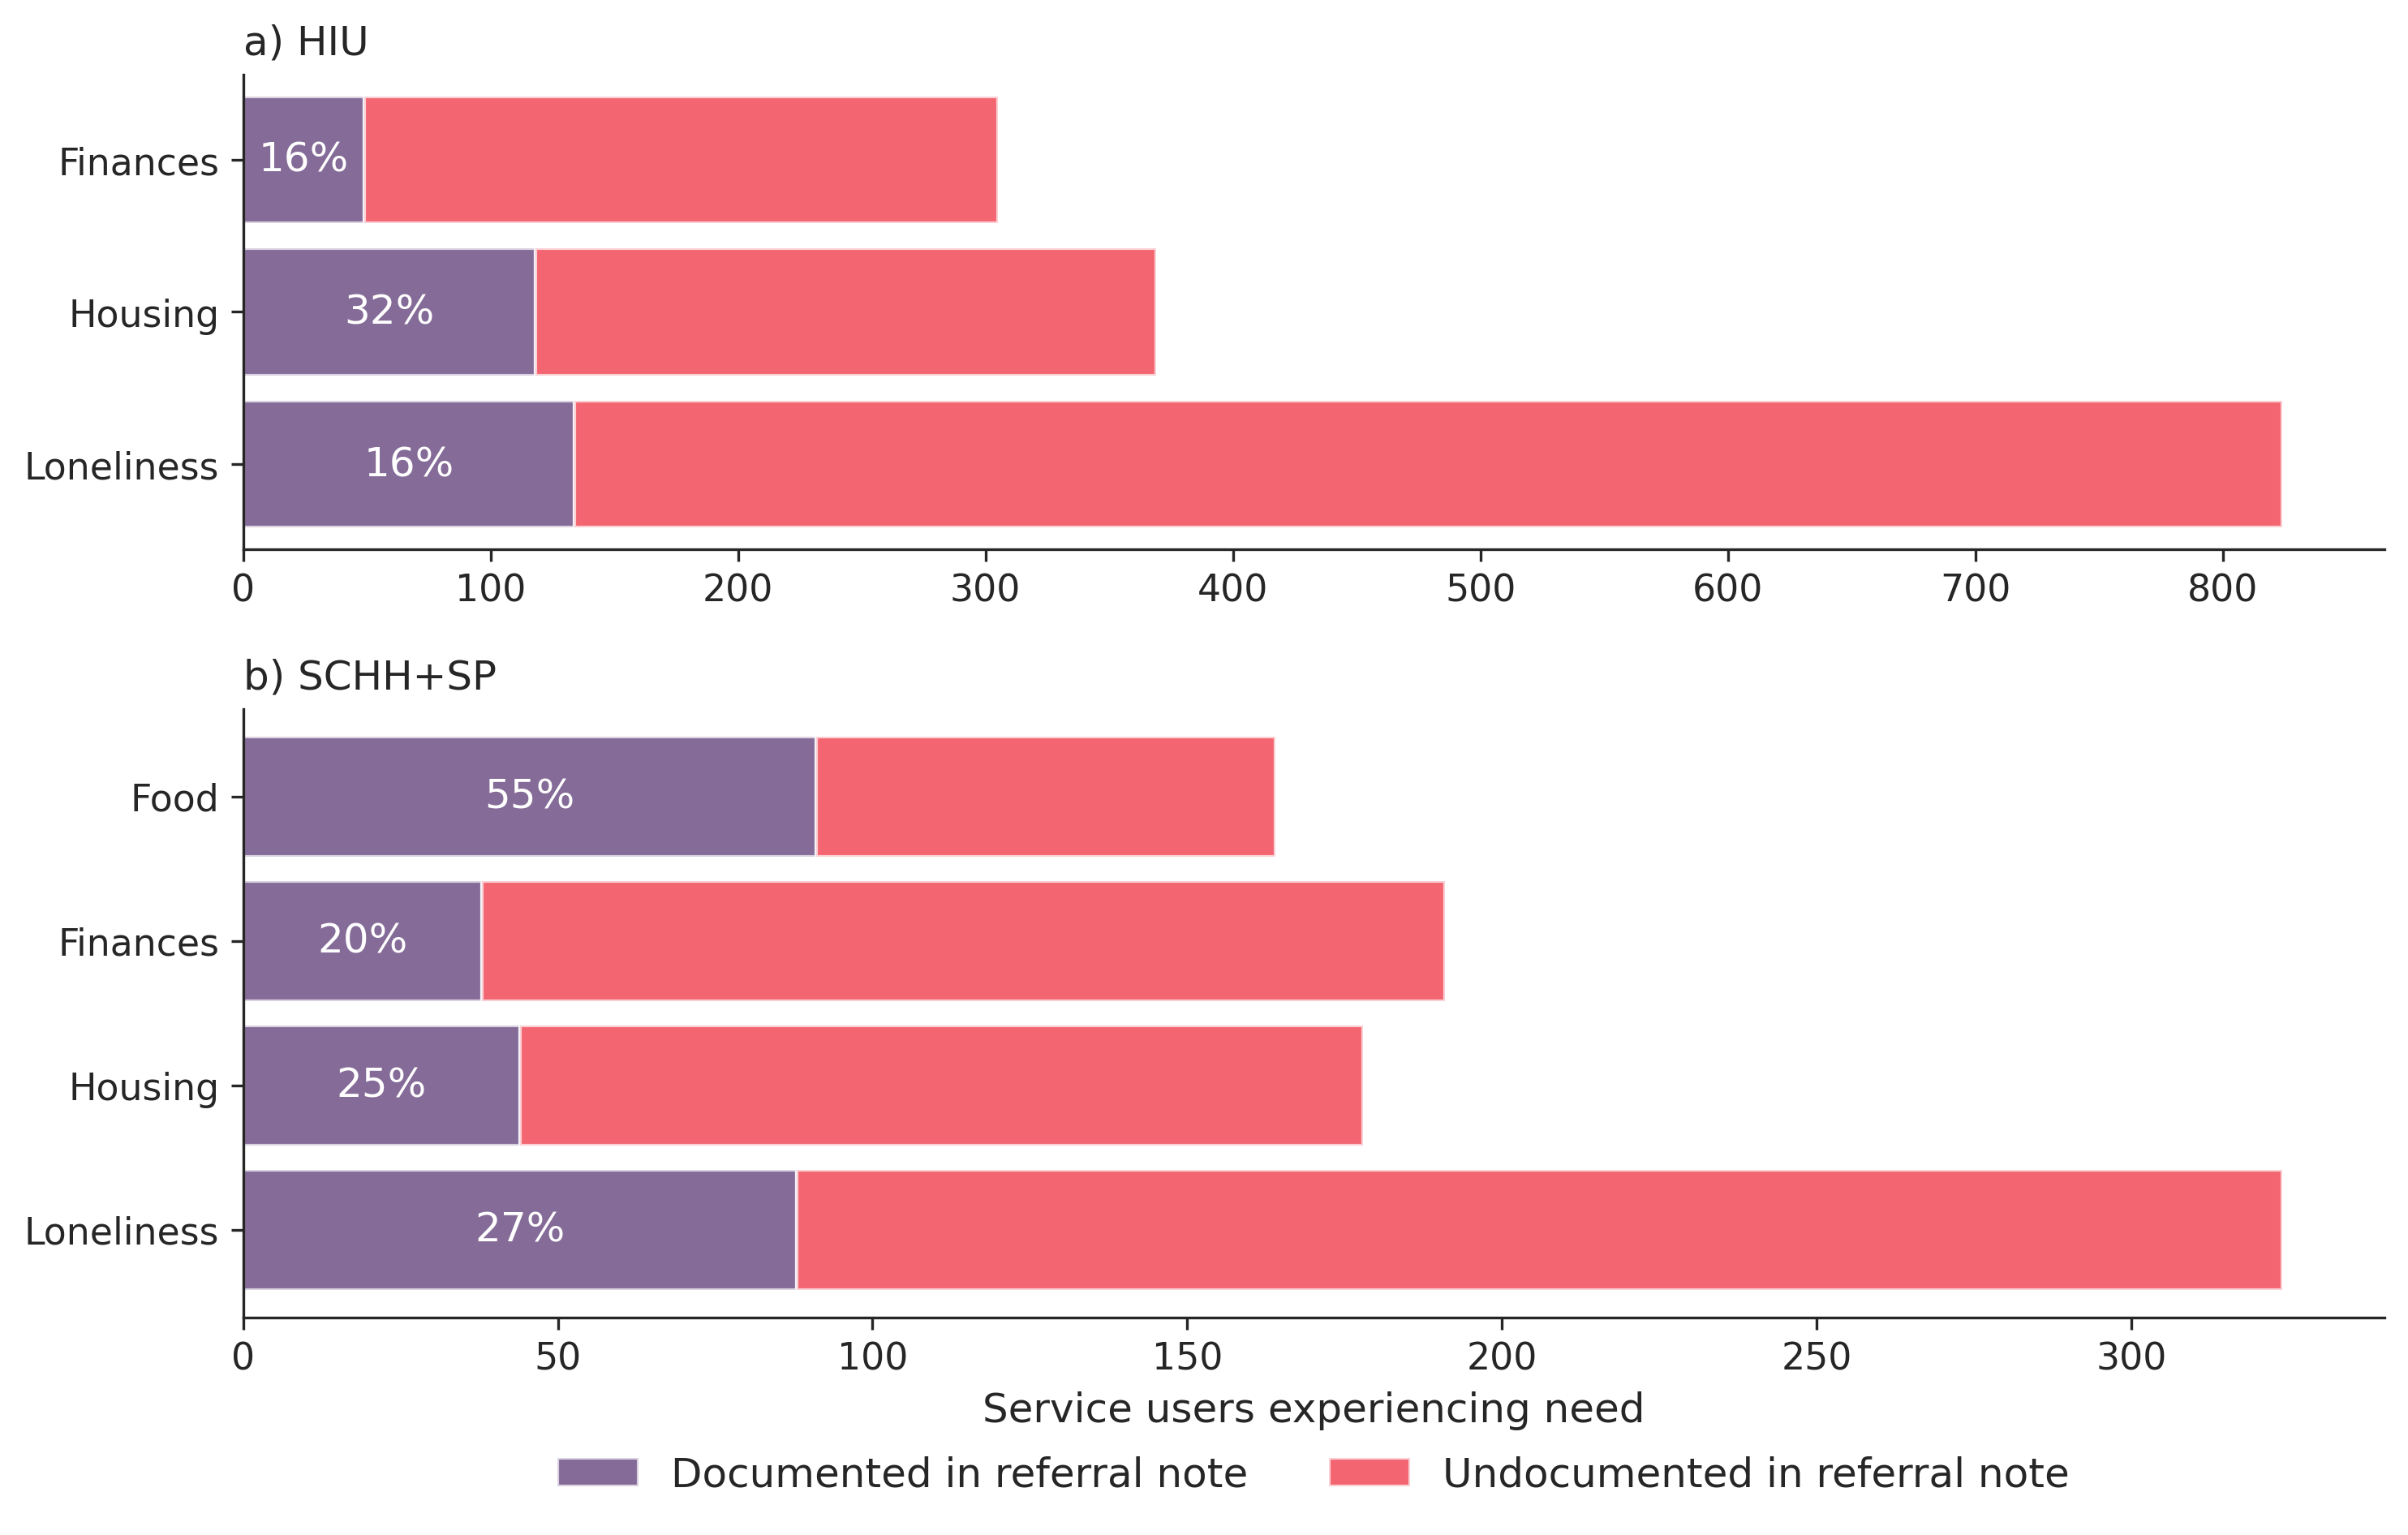

In [118]:
from src.visualisations_helpers import plot_stacked_horizontal_single

plot_stacked_horizontal_single(
    df_combined_long,
    dataset="HIU",
    save_path="../results/figures/hiu_need_recall.png",
    figsize=(10, 2.7)
)

plot_stacked_horizontal_single(
    df_combined_long,
    dataset="SNAP",
    save_path="../results/figures/schh_need_recall.png",
    figsize=(10, 4),
)

from PIL import Image

img_top = Image.open("../results/figures/hiu_need_recall.png")
img_bottom = Image.open("../results/figures/schh_need_recall.png")

# Create new canvas: same width, sum of heights
combined_height = img_top.height + img_bottom.height
combined = Image.new('RGB', (img_top.width, combined_height), (255, 255, 255))

# Paste one on top of the other
combined.paste(img_top, (0, 0))
combined.paste(img_bottom, (0, img_top.height))

combined.save("../results/figures/combined_need_recall.png")
combined.show()

### 2.3. Accounting for model uncertainty in SDoH documentation estimates
The proportion of Social Determinants of Health (SDoH) needs captured in referral notes is computed by comparing structured ground-truth needs to those detected by a fine-tuned language model. However, this estimate is influenced by the **performance of the model**—specifically, its **precision** and **recall**.

### 2.4. Exhautiveness by characteristics of the SU

### 2.5. Exhaustiveness by referrer

In [8]:
# Load the referrals data
referrals_path = "../data/processed/brc-cleaned/referrals_cleaned.csv"
df_referrals = pd.read_csv(referrals_path)

# Drop any duplicate columns before merge (if any exist, e.g. case_ref)
df_referrals = df_referrals.loc[:, ~df_referrals.columns.duplicated()]

# Ensure 'case_ref' is string type to avoid mismatches
df_referrals["case_ref"] = df_referrals["case_ref"].astype(str)
df_combined_long["case_ref"] = df_combined_long["case_ref"].astype(str)

# Merge
df_merged = df_combined_long.merge(df_referrals, on="case_ref", how="left", suffixes=("", "_referral"))

In [9]:
df_referrals.columns

Index(['Area', 'Scheme', 'Case Reference', 'Assessment Result', 'Case Status',
       'Referral Date/Time', 'End Date Case', 'Has Disability', 'Has Risk',
       'Risk Type', 'Unique Case', 'IMD_decile', 'Country', 'Age', 'Gender',
       'Ethnicity', 'Disability', 'Living Arrangements',
       'Referral Notes (depersonalised)', 'case_ref', 'num_observations',
       'date_range_start', 'date_range_end', 'date_range_days',
       'referral_date'],
      dtype='object')